In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFilter
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.utils import save_image
import os

### Initialize device

In [3]:
ngpu = 1
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Parameters for loading model, defining architecture, and forward propagation

In [5]:
# Path to the .pth file
baseline_path = '../models/baseline_dcgan/5/model.pth'
second_stage_path = '../models/second_stage/ResNet_6/early_stop-350433/netG.pth'
third_stage_path = '../models/third_stage/ResNet_6/early_stop-400/netG.pth'

# Output directory
output_dir = '../models/StackGan/results/'

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in baseline generator
ngf_baseline = 128

# Size of feature maps in second stage generator
ngf_second_stage = 64

# Constant noise vector. This is fine since we only do one forward pass of the network in this notebook.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

### Initialize any directories

In [6]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Define model architectures

#### Baseline generator (noise to edges)

In [7]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf_baseline * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf_baseline * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf_baseline * 16, ngf_baseline * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf_baseline * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf_baseline * 8, ngf_baseline * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf_baseline * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf_baseline * 4, ngf_baseline * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf_baseline * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf_baseline * 2, ngf_baseline, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf_baseline),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf_baseline, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

#### Second stage (edges to grayscale)

In [8]:
class ResnetBlock(nn.Module):

    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
        ]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        # Skip connection
        return x + self.conv_block(x)

class StageTwo(nn.Module):
    def __init__(self):
        super(StageTwo, self).__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(nc, ngf_second_stage, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf_second_stage),
            nn.ReLU(True),
        ]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [
                nn.Conv2d(
                    ngf_second_stage * mult,
                    ngf_second_stage * mult * 2,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(ngf_second_stage * mult * 2),
                nn.ReLU(True),
            ]

        mult = 2 ** n_downsampling
        for i in range(6):  # ResNet-6 requires 6 blocks

            model += [
                ResnetBlock(ngf_second_stage * mult)
            ]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(
                    ngf_second_stage * mult,
                    int(ngf_second_stage * mult / 2),
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(int(ngf_second_stage * mult / 2)),
                nn.ReLU(True),
            ]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf_second_stage, 1, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

#### Third stage (grayscale to RGB)

In [9]:
class StageThree(nn.Module):
    def __init__(self):
        super(StageThree, self).__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(nc, ngf_second_stage, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf_second_stage),
            nn.ReLU(True),
        ]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [
                nn.Conv2d(
                    ngf_second_stage * mult,
                    ngf_second_stage * mult * 2,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(ngf_second_stage * mult * 2),
                nn.ReLU(True),
            ]

        mult = 2 ** n_downsampling
        for i in range(6):  # ResNet-6 requires 6 blocks

            model += [
                ResnetBlock(ngf_second_stage * mult)
            ]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(
                    ngf_second_stage * mult,
                    int(ngf_second_stage * mult / 2),
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(int(ngf_second_stage * mult / 2)),
                nn.ReLU(True),
            ]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf_second_stage, 3, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

### Load trained generators

In [10]:
baseline = Baseline()
second_stage = StageTwo()
third_stage = StageThree()

baseline.load_state_dict(torch.load(baseline_path, map_location=device))
second_stage.load_state_dict(torch.load(second_stage_path, map_location=device))
third_stage.load_state_dict(torch.load(third_stage_path, map_location=device))

<All keys matched successfully>

### Visualize generated images

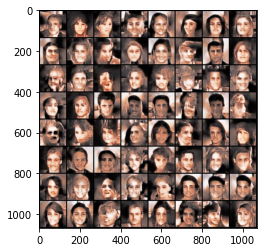

In [13]:
with torch.no_grad():
    # Generate batch of fake edges images
    fake_edges = baseline(fixed_noise).to(device)
    
    # Generate batch of fake grayscale images
    fake_grayscale = second_stage(fake_edges).to(device)
    
    # Generate batch of fake rgb images
    fake_rgb = third_stage(fake_grayscale).to(device)
    
    # Put generated images into a grid
    edges_grid = np.transpose(vutils.make_grid(fake_edges, padding = 5, normalize=True), (1, 2, 0))
    grayscale_grid = np.transpose(vutils.make_grid(fake_grayscale, padding = 5, normalize=True), (1, 2, 0))
    final_grid = np.transpose(vutils.make_grid(fake_rgb, padding = 5, normalize=True), (1, 2, 0))
    
    # Display and save grid
    plt.imshow(final_grid)
    plt.imsave(output_dir + 'edges.png', np.array(edges_grid))
    plt.imsave(output_dir + 'grayscale.png', np.array(grayscale_grid))
    plt.imsave(output_dir + 'final.png', np.array(final_grid))